<a href="https://colab.research.google.com/github/spehl-max/recommendationExperiment/blob/main/Recommendation_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Consistency Evaluation
## *Do LLMs Agree With Their Own Investment Advice?*

### Written By: Max Spehlmann

## Setup and Dependencies

### Packages

In [ ]:
!pip install anthropic
!pip install --upgrade openai
from openai import OpenAI
from anthropic import Anthropic, HUMAN_PROMPT, AI_PROMPT
import pandas as pd
import numpy as np
import json
import time
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.8/767.8 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.98.0
    Uninstalling openai-1.98.0:
      Successfully uninstalled openai-1.98.0


### API Keys and Models

In [ ]:
os.environ["CLAUDE_API_KEY"] = "YOUR_KEY_HERE"
os.environ["OPENAI_API_KEY"] = "YOUR_KEY_HERE"

anthropic_client = Anthropic(api_key=os.environ.get("CLAUDE_API_KEY"))

MODEL_CLAUDE = "claude-sonnet-4-20250514"

openai_client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

MODEL_OPENAI = "o1-mini"

### Sample Blackrock Market Report

*https://www.blackrock.com/us/individual/insights/blackrock-investment-institute/weekly-commentary#asset-class-views*

*Accessed, 8/5/25*

In [ ]:
MARKET_REPORT = """
Weekly commentary August 4, 2025 U.S. tug-of-war: earnings vs. tariffs

* U.S. corporate earnings resilience persists as tariff impacts become clearer. We stay overweight U.S. stocks but get granular while assessing the tariff fallout.
* U.S. stocks fell and bond yields slid after soft U.S. jobs data suggested slowing activity. We see many macro crosscurrents at play, muddying the outlook.
* U.S. trade data will show how much tariffs are impacting imports. The Bank of England is expected to cut policy rates.

We see risk assets in a tug-of-war between solid U.S. corporate earnings, powered by the artificial intelligence (AI) theme, and tariffs hurting growth while lifting inflation. Q2 earnings results suggest the AI theme is winning, but questions remain about who will pay for tariffs. Early signs indicate a mix of consumers and companies. We think U.S. corporate strength could cushion the blow and stay overweight the AI theme and U.S. stocks. We get granular when eying the tariff hit.

The U.S. "reciprocal" tariffs announced on April 2, which stoked historic market volatility, are now taking shape as the U.S. reaches agreements or imposes higher levies. U.S. tariffs on imports are now ending up at an effective rate around 15-20%, higher than we expected earlier this year, and generated revenues of $27 billion in June, Treasury data show. That means someone is paying the tariffs – and how much they hurt growth and stoke inflation will depend on who pays. Ultimately it is some mix of foreign suppliers, U.S. companies via profit margins and consumers via inflation. Yet U.S. corporate earnings are robust: Q2 U.S. earnings are up about 8% year-over-year even with tariffs, LSEG data show. U.S. profit margins are at record highs relative to flat margins in Europe. See the chart. U.S. mega cap tech is lifting AI investment as seen with Microsoft and Meta last week.
The slew of trade agreements announced in recent weeks removes some of the uncertainty of the ultimate effective landing zone for tariffs – even if they're several times higher than where they were at the end of 2024. The tariff impact on U.S. consumers has been slow to show up in part because companies rushed to import goods before expected tariffs in April. Tariffs do not apply to ships that left the port, shipping can take several weeks and companies can delay payments even when goods arrive. Many have not yet raised prices until they have greater clarity. Yet that offset is fading: second quarter U.S. inflation data showed durable goods prices rising at the fastest pace since 1991 outside the pandemic. So consumers are starting to pay some of the tariff costs, especially in household appliances and electronics. And companies have also started paying: global automakers, some of the most exposed to tariffs, are reporting large earnings writedowns.

Automakers highlight how complicated the tariff story is. U.S. automakers like General Motors and Ford are among those taking the large profit hits as tariffs are implemented – and chose to eat the tariffs. Japanese and South Korean automakers are absorbing tariff costs by cutting the prices of the vehicles they sell to the U.S. This pressure on pricing is especially acute in Europe where automakers battle with China's cheaper electric vehicles and are constrained in raising prices. By contrast, quality producers like Ferrari are lifting prices – highlighting the importance of pricing power.
This is why corporate earnings resilience matters, in our view. Automakers are manufacturers. The industrials sector – where supply chains are among the most integrated globally – is dominated by manufacturers and is likely feeling the biggest impact of tariffs. And yet the industrials sector is the best-performing S&P 500 sector this year, up some 15% compared with 6% for the index, according to LSEG data. Why? Industrials benefit from the AI buildout and other key themes driven by mega forces, such as geopolitical fragmentation and the boost to defense spending this year. That's why this environment favors getting granular with views below the sector level and favors an active approach to achieving returns.
Bottom line: We see a tug-of-war between the economic drag of tariffs and U.S. corporate earnings strength driven by AI. The latter is winning so far, in our view, but getting granular views is key as companies and consumers each eat tariff costs.
Market backdrop U.S. stocks retreated for the week after pushing to new all-time highs, with the S&P 500 down about 2% for the week. Surprisingly weak payrolls data put stocks under pressure and pushed down Treasury yields on expectations for Federal Reserve rate cuts. We think the payrolls data shows activity slowing but that there are several crosscurrents at play when it comes to inflation (sticky wage growth, tariffs) and for risk assets (the AI theme holding up even as activity has slowed).
"""

print("✅ Sample financial report loaded")
print(f"📄 Document length: {len(MARKET_REPORT)} characters")

✅ Sample financial report loaded
📄 Document length: 4925 characters


## Main Orchestrator Class

In [ ]:
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class SimplifiedConsistencyExperiment:
    def __init__(self, anthropic_client, openai_client, claude_model, openai_model, earnings_statement,
                 n_evaluation_reps=3, test_mode=False):
        self.anthropic_client = anthropic_client
        self.openai_client = openai_client
        self.claude_model = claude_model
        self.openai_model = openai_model
        self.earnings_statement = earnings_statement
        self.n_evaluation_reps = n_evaluation_reps
        self.test_mode = test_mode
        self.results = {
            'claude_recommendations': [],
            'openai_recommendations': [],
            'claude_evaluations': [],  # Claude evaluating its own recs
            'openai_evaluations': [],  # OpenAI evaluating its own recs
            'analysis_summary': []  # Per-recommendation consistency stats
        }

    def extract_json_from_response(self, response: str) -> dict:
        """Extract JSON from LLM response, handling cases where extra text is included"""
        try:
            return json.loads(response)
        except json.JSONDecodeError:
            import re

            # Find content between { and } (including nested braces)
            json_pattern = r'\{(?:[^{}]|{[^{}]*})*\}'
            matches = re.findall(json_pattern, response, re.DOTALL)

            if matches:
                for match in matches:
                    try:
                        return json.loads(match)
                    except json.JSONDecodeError:
                        continue

            # Try to extract content between ```json and ```
            code_block_pattern = r'```json\s*(.*?)\s*```'
            code_matches = re.findall(code_block_pattern, response, re.DOTALL | re.IGNORECASE)

            if code_matches:
                for match in code_matches:
                    try:
                        return json.loads(match)
                    except json.JSONDecodeError:
                        continue

            raise json.JSONDecodeError(f"Could not extract valid JSON from response: {response[:200]}...")

    def call_claude(self, prompt: str, max_retries: int = 3) -> str:
        """Make API call to Claude with retry logic"""
        for attempt in range(max_retries):
            try:
                response = self.anthropic_client.messages.create(
                    model=self.claude_model,
                    max_tokens=4000,
                    messages=[{"role": "user", "content": prompt}]
                )
                return response.content[0].text
            except Exception as e:
                print(f"Claude attempt {attempt + 1} failed: {e}")
                if attempt < max_retries - 1:
                    time.sleep(2 ** attempt)
                else:
                    raise e

    def call_openai(self, prompt: str, max_retries: int = 3) -> str:
        """Make API call to OpenAI with retry logic"""
        for attempt in range(max_retries):
            try:
                response = self.openai_client.chat.completions.create(
                    model=self.openai_model,
                    messages=[{"role": "user", "content": prompt}]
                )
                return response.choices[0].message.content
            except Exception as e:
                print(f"OpenAI attempt {attempt + 1} failed: {e}")
                if attempt < max_retries - 1:
                    time.sleep(2 ** attempt)
                else:
                    raise e

    def generate_recommendations(self):
        """Generate recommendations from both models"""
        print("PHASE 1: Generating recommendations from both models...")
        print("-" * 60)

        prompt = f"""
        Read this earnings statement and generate ten investment recommendations for a retail investor.

        Each recommendation should be:
        -Data-Driven
        -Clear and actionable
        -Risk-Aware
        -Measureable

        Print your recommendations in order of most to least confidence.
        I.e, the first recommendation should be the recommendation for which you are most confident, and the tenth recommendation should be the recommendation for which you are least confident.

        Earnings Statement:
        {self.earnings_statement}
        Generate your response in JSON format:
        {{
            "ten_recommendations": ["rec 1", "rec 2", ..., "rec 10"]
        }}
        Do not include any text in your response that is not part of the JSON response. The recommendation should be a single string, not a nested value.
        """

        # Generate Claude's recommendations
        print("→ Generating recommendations from Claude...")
        claude_response = self.call_claude(prompt)
        claude_data = self.extract_json_from_response(claude_response)

        for i, rec in enumerate(claude_data['ten_recommendations']):
            confidence = 10 - i  # 1st rec = 10, 2nd rec = 9, ..., 10th rec = 1
            self.results['claude_recommendations'].append({
                'id': f"claude_{i+1}",
                'recommendation': rec,
                'confidence': confidence
            })

        # Generate OpenAI's recommendations
        print("→ Generating recommendations from OpenAI...")
        openai_response = self.call_openai(prompt)
        openai_data = self.extract_json_from_response(openai_response)

        for i, rec in enumerate(openai_data['ten_recommendations']):
            confidence = 10 - i  # 1st rec = 10, 2nd rec = 9, ..., 10th rec = 1
            self.results['openai_recommendations'].append({
                'id': f"openai_{i+1}",
                'recommendation': rec,
                'confidence': confidence
            })

        print(f"✓ Generated recommendations:")
        print(f"  - Claude: {len(self.results['claude_recommendations'])}")
        print(f"  - OpenAI: {len(self.results['openai_recommendations'])}")

    def evaluate_own_recommendations(self):
        """Each model evaluates its own recommendations n times"""
        print(f"\nPHASE 2: Self-evaluation ({self.n_evaluation_reps} reps each)...")
        print("-" * 60)

        eval_prompt_template = """
        You are evaluating a retail investment recommendation based on a market report. Please determine if the recommendation is good or bad.

        A good recommendation should be:
        -Data-Driven
        -Clear and actionable
        -Risk-Aware
        -Measureable

        Earnings Statement:
        {earnings_statement}

        Recommendation:
        {recommendation}

        Output your evaluation in JSON format:
        {{
            "good_bad": "good" or "bad"
        }}

        Do not include any text in your response that is not part of the JSON response.
        """

        # Claude evaluates its own recommendations
        claude_recs = (self.results['claude_recommendations'][:2]
                      if self.test_mode
                      else self.results['claude_recommendations'])

        print(f"→ Claude evaluating its own {len(claude_recs)} recommendations...")
        for i, rec_data in enumerate(claude_recs):
            print(f"   Recommendation {i+1}/{len(claude_recs)}: {rec_data['id']}")

            for rep in range(self.n_evaluation_reps):
                prompt = eval_prompt_template.format(
                    earnings_statement=self.earnings_statement,
                    recommendation=rec_data['recommendation']
                )

                response = self.call_claude(prompt)
                eval_data = self.extract_json_from_response(response)

                self.results['claude_evaluations'].append({
                    'rec_id': rec_data['id'],
                    'rep_number': rep + 1,
                    'evaluation': eval_data['good_bad']
                })

                time.sleep(0.5)

        # OpenAI evaluates its own recommendations
        openai_recs = (self.results['openai_recommendations'][:2]
                      if self.test_mode
                      else self.results['openai_recommendations'])

        print(f"→ OpenAI evaluating its own {len(openai_recs)} recommendations...")
        for i, rec_data in enumerate(openai_recs):
            print(f"   Recommendation {i+1}/{len(openai_recs)}: {rec_data['id']}")

            for rep in range(self.n_evaluation_reps):
                prompt = eval_prompt_template.format(
                    earnings_statement=self.earnings_statement,
                    recommendation=rec_data['recommendation']
                )

                response = self.call_openai(prompt)
                eval_data = self.extract_json_from_response(response)

                self.results['openai_evaluations'].append({
                    'rec_id': rec_data['id'],
                    'rep_number': rep + 1,
                    'evaluation': eval_data['good_bad']
                })

                time.sleep(0.5)

        print(f"✓ Completed self-evaluations")
        print(f"  - Claude evaluations: {len(self.results['claude_evaluations'])}")
        print(f"  - OpenAI evaluations: {len(self.results['openai_evaluations'])}")

    def analyze_consistency(self):
        """Analyze consistency for each recommendation"""
        print("\nPHASE 3: Analyzing consistency...")
        print("-" * 60)

        self.results['analysis_summary'] = []

        # Analyze Claude's consistency
        claude_df = pd.DataFrame(self.results['claude_evaluations'])
        if len(claude_df) > 0:
            for rec_id in claude_df['rec_id'].unique():
                rec_evals = claude_df[claude_df['rec_id'] == rec_id]

                total_evals = len(rec_evals)
                good_count = len(rec_evals[rec_evals['evaluation'] == 'good'])
                bad_count = len(rec_evals[rec_evals['evaluation'] == 'bad'])

                good_percent = (good_count / total_evals) * 100
                bad_percent = (bad_count / total_evals) * 100

                # Inconsistency percentage = percentage that were inconsistent with original "good" assessment
                inconsistency_percent = bad_percent

                rec_text = next(r['recommendation'] for r in self.results['claude_recommendations']
                              if r['id'] == rec_id)
                rec_confidence = next(r['confidence'] for r in self.results['claude_recommendations']
                                    if r['id'] == rec_id)

                self.results['analysis_summary'].append({
                    'model': 'claude',
                    'rec_id': rec_id,
                    'recommendation': rec_text,
                    'confidence': rec_confidence,
                    'total_evaluations': total_evals,
                    'good_count': good_count,
                    'bad_count': bad_count,
                    'good_percent': good_percent,
                    'bad_percent': bad_percent,
                    'inconsistency_percent': inconsistency_percent,
                    'is_perfectly_consistent': inconsistency_percent == 0
                })

        # Analyze OpenAI's consistency
        openai_df = pd.DataFrame(self.results['openai_evaluations'])
        if len(openai_df) > 0:
            for rec_id in openai_df['rec_id'].unique():
                rec_evals = openai_df[openai_df['rec_id'] == rec_id]

                total_evals = len(rec_evals)
                good_count = len(rec_evals[rec_evals['evaluation'] == 'good'])
                bad_count = len(rec_evals[rec_evals['evaluation'] == 'bad'])

                good_percent = (good_count / total_evals) * 100
                bad_percent = (bad_count / total_evals) * 100

                # Inconsistency percentage = percentage that were inconsistent with original "good" assessment
                inconsistency_percent = bad_percent

                rec_text = next(r['recommendation'] for r in self.results['openai_recommendations']
                              if r['id'] == rec_id)
                rec_confidence = next(r['confidence'] for r in self.results['openai_recommendations']
                                    if r['id'] == rec_id)

                self.results['analysis_summary'].append({
                    'model': 'openai',
                    'rec_id': rec_id,
                    'recommendation': rec_text,
                    'confidence': rec_confidence,
                    'total_evaluations': total_evals,
                    'good_count': good_count,
                    'bad_count': bad_count,
                    'good_percent': good_percent,
                    'bad_percent': bad_percent,
                    'inconsistency_percent': inconsistency_percent,
                    'is_perfectly_consistent': inconsistency_percent == 0
                })

        print(f"✓ Analyzed consistency for {len(self.results['analysis_summary'])} recommendations")

    def show_consistency_summary(self):
        """Show summary of consistency analysis"""
        if not self.results['analysis_summary']:
            print("No analysis available. Run analyze_consistency() first.")
            return

        print("\nCONSISTENCY ANALYSIS SUMMARY:")
        print("=" * 80)

        df = pd.DataFrame(self.results['analysis_summary'])
        df['consistency_percent'] = 100 - df['inconsistency_percent']

        # Overall stats
        total_recs = len(df)
        perfectly_consistent = len(df[df['is_perfectly_consistent'] == True])
        avg_consistency_percent = df['consistency_percent'].mean()

        print(f"Total recommendations analyzed: {total_recs}")
        print(f"Perfectly consistent: {perfectly_consistent}/{total_recs} ({perfectly_consistent/total_recs*100:.1f}%)")
        print(f"Average consistency percentage: {avg_consistency_percent:.1f}%")

        # By model
        print(f"\nBy Model:")
        for model in ['claude', 'openai']:
            model_data = df[df['model'] == model]
            if len(model_data) > 0:
                model_consistent = len(model_data[model_data['is_perfectly_consistent'] == True])
                model_avg_consistency = model_data['consistency_percent'].mean()
                print(f"  {model.upper()}:")
                print(f"    Perfectly consistent: {model_consistent}/{len(model_data)} ({model_consistent/len(model_data)*100:.1f}%)")
                print(f"    Avg consistency percentage: {model_avg_consistency:.1f}%")

        # Show worst performers (lowest consistency)
        print(f"\nLeast Consistent Recommendations (lowest consistency %):")
        worst = df.nsmallest(5, 'consistency_percent')
        for _, row in worst.iterrows():
            print(f"  {row['rec_id']} [{row['model'].upper()}]: {row['consistency_percent']:.1f}% consistent (confidence: {row['confidence']})")
            print(f"    ({row['good_count']} good, {row['bad_count']} bad out of {row['total_evaluations']})")
            print(f"    \"{row['recommendation'][:60]}...\"")
            print()

    def show_detailed_breakdown(self):
        """Show detailed breakdown for each recommendation"""
        if not self.results['analysis_summary']:
            print("No analysis available.")
            return

        print("\nDETAILED CONSISTENCY BREAKDOWN:")
        print("=" * 80)

        df = pd.DataFrame(self.results['analysis_summary'])
        df['consistency_percent'] = 100 - df['inconsistency_percent']

        for _, row in df.iterrows():
            status = "✓ PERFECTLY CONSISTENT" if row['is_perfectly_consistent'] else f"⚠ {row['consistency_percent']:.1f}% CONSISTENT"

            print(f"{row['rec_id']} [{row['model'].upper()}] - {status} (confidence: {row['confidence']})")
            print(f"  Good: {row['good_count']}/{row['total_evaluations']} ({row['good_percent']:.1f}%)")
            print(f"  Bad: {row['bad_count']}/{row['total_evaluations']} ({row['bad_percent']:.1f}%)")
            print(f"  Recommendation: \"{row['recommendation'][:80]}...\"")
            print()

    def create_inconsistency_histogram(self):
        """Create histogram of consistency percentages by model"""
        if not self.results['analysis_summary']:
            print("No analysis available for visualization.")
            return

        df = pd.DataFrame(self.results['analysis_summary'])
        df['consistency_percent'] = 100 - df['inconsistency_percent']

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Consistency percentage histogram by model
        claude_data = df[df['model'] == 'claude']['consistency_percent']
        openai_data = df[df['model'] == 'openai']['consistency_percent']

        if len(claude_data) > 0 and len(openai_data) > 0:
            axes[0].hist([claude_data, openai_data], bins=8, alpha=0.7,
                        label=['Claude', 'OpenAI'], color=['blue', 'orange'], edgecolor='black')
            axes[0].set_title(f'Consistency Percentage by Model\n({self.n_evaluation_reps} evaluations per recommendation)')
            axes[0].set_xlabel('Consistency Percentage (%)')
            axes[0].set_ylabel('Number of Recommendations')
            axes[0].legend()

        # Scatter plot: Confidence vs Consistency Percentage
        claude_scatter = df[df['model'] == 'claude']
        openai_scatter = df[df['model'] == 'openai']

        if len(claude_scatter) > 0:
            axes[1].scatter(claude_scatter['confidence'], claude_scatter['consistency_percent'],
                           color='blue', alpha=0.7, label='Claude', s=60)
        if len(openai_scatter) > 0:
            axes[1].scatter(openai_scatter['confidence'], openai_scatter['consistency_percent'],
                           color='orange', alpha=0.7, label='OpenAI', s=60)

        axes[1].set_title('Confidence vs Consistency')
        axes[1].set_xlabel('Initial Confidence Rating (1-10)')
        axes[1].set_ylabel('Consistency Percentage (%)')
        axes[1].set_xlim(0.5, 10.5)
        axes[1].set_ylim(-5, 105)
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()

        # Calculate and display correlations
        if len(claude_scatter) > 1:
            claude_corr = np.corrcoef(claude_scatter['confidence'], claude_scatter['consistency_percent'])[0, 1]
            axes[1].text(0.02, 0.98, f'Claude correlation: {claude_corr:.3f}',
                        transform=axes[1].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

        if len(openai_scatter) > 1:
            openai_corr = np.corrcoef(openai_scatter['confidence'], openai_scatter['consistency_percent'])[0, 1]
            axes[1].text(0.02, 0.88, f'OpenAI correlation: {openai_corr:.3f}',
                        transform=axes[1].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7))

        plt.tight_layout()
        plt.show()

    def load_from_json(self, filename: str):
        """Load previous results from JSON file"""
        with open(filename, 'r') as f:
            self.results = json.load(f)
        print(f"✓ Results loaded from {filename}")
        print(f"  - Claude recommendations: {len(self.results.get('claude_recommendations', []))}")
        print(f"  - OpenAI recommendations: {len(self.results.get('openai_recommendations', []))}")
        print(f"  - Claude evaluations: {len(self.results.get('claude_evaluations', []))}")
        print(f"  - OpenAI evaluations: {len(self.results.get('openai_evaluations', []))}")


    def get_article_facts(self):
        """Get key facts for article writing in string format"""
        if not self.results['analysis_summary']:
            return "No analysis available. Run analyze_consistency() first."

        df = pd.DataFrame(self.results['analysis_summary'])
        df['consistency_percent'] = 100 - df['inconsistency_percent']

        # Calculate key metrics
        total_recs = len(df)
        recs_with_some_inconsistency = len(df[df['inconsistency_percent'] > 0])
        recs_rated_bad_100_percent = len(df[df['inconsistency_percent'] == 100])

        percent_with_some_inconsistency = (recs_with_some_inconsistency / total_recs) * 100
        avg_consistency = df['consistency_percent'].mean()

        # By model breakdown
        claude_df = df[df['model'] == 'claude']
        openai_df = df[df['model'] == 'openai']

        claude_some_inconsistency = len(claude_df[claude_df['inconsistency_percent'] > 0])
        openai_some_inconsistency = len(openai_df[openai_df['inconsistency_percent'] > 0])

        claude_100_bad = len(claude_df[claude_df['inconsistency_percent'] == 100])
        openai_100_bad = len(openai_df[openai_df['inconsistency_percent'] == 100])

        # Confidence correlation (if available)
        correlation_text = ""
        if 'confidence' in df.columns:
            if len(claude_df) > 1:
                claude_corr = np.corrcoef(claude_df['confidence'], claude_df['consistency_percent'])[0, 1]
                correlation_text += f"Claude confidence-consistency correlation: {claude_corr:.3f}\n"
            if len(openai_df) > 1:
                openai_corr = np.corrcoef(openai_df['confidence'], openai_df['consistency_percent'])[0, 1]
                correlation_text += f"OpenAI confidence-consistency correlation: {openai_corr:.3f}\n"

        # Generate article facts
        facts = f"""ARTICLE FACTS:

KEY INCONSISTENCY METRICS:
- {percent_with_some_inconsistency:.1f}% of recommendations showed some inconsistency (rated as 'bad' at least once)
- {recs_rated_bad_100_percent} recommendations were rated as 'bad' 100% of the time
- Average consistency across all recommendations: {avg_consistency:.1f}%
- Total recommendations analyzed: {total_recs} ({self.n_evaluation_reps} evaluations each)

BY MODEL BREAKDOWN:
Claude:
- {claude_some_inconsistency}/{len(claude_df)} recommendations showed inconsistency ({(claude_some_inconsistency/len(claude_df)*100):.1f}%)
- {claude_100_bad} recommendations rated 'bad' 100% of the time
- Average consistency: {claude_df['consistency_percent'].mean():.1f}%

OpenAI:
- {openai_some_inconsistency}/{len(openai_df)} recommendations showed inconsistency ({(openai_some_inconsistency/len(openai_df)*100):.1f}%)
- {openai_100_bad} recommendations rated 'bad' 100% of the time
- Average consistency: {openai_df['consistency_percent'].mean():.1f}%

{correlation_text}
ARTICLE-READY SENTENCES:
"I measured its response {self.n_evaluation_reps} times per recommendation. {percent_with_some_inconsistency:.1f}% of the time the LLM rated its own 'good' advice as 'bad' at least one time. For {recs_rated_bad_100_percent} recommendations, the LLM rated its advice as 'bad' {100}% percent of the time! Not too confidence inspiring for our free financial advisor."

"On average, the models were consistent with their own recommendations {avg_consistency:.1f}% of the time."
        """

        print(facts)
        return facts

    def export_charts(self, filename_prefix='llm_consistency', dpi=150):
        """Export both charts as separate high-quality images for publication"""
        if not self.results['analysis_summary']:
            print("No analysis available for visualization.")
            return

        df = pd.DataFrame(self.results['analysis_summary'])
        df['consistency_percent'] = 100 - df['inconsistency_percent']

        # Set font for export
        plt.rcParams['font.family'] = ['DejaVu Sans', 'Liberation Sans', 'sans-serif']

        # Chart 1: Consistency Histogram
        fig1, ax1 = plt.subplots(1, 1, figsize=(10, 6))
        claude_data = df[df['model'] == 'claude']['consistency_percent']
        openai_data = df[df['model'] == 'openai']['consistency_percent']

        if len(claude_data) > 0 and len(openai_data) > 0:
            # Define bin edges for clear boundaries
            bin_edges = [0, 12.5, 25, 37.5, 50, 62.5, 75, 87.5, 100]
            ax1.hist([claude_data, openai_data], bins=bin_edges, alpha=0.8,
                    label=['Claude', 'OpenAI'], color=['#2E86C1', '#F39C12'],
                    edgecolor='black', histtype='stepfilled', rwidth=0.8)

        ax1.set_xlabel('Consistency Percentage (%)', fontsize=18)
        ax1.set_ylabel('Number of Recommendations', fontsize=18)
        ax1.set_ylim(0, 10)  # Set y-axis max to 10
        ax1.set_yticks([0, 2, 4, 6, 8, 10])  # Clean y-axis intervals
        # Set x-axis ticks to show bin boundaries
        ax1.set_xticks([0, 12.5, 25, 37.5, 50, 62.5, 75, 87.5, 100])
        ax1.legend(fontsize=16)
        ax1.tick_params(axis='both', which='major', labelsize=15)
        plt.tight_layout()

        filename1 = f"{filename_prefix}_histogram.png"
        plt.savefig(filename1, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"✓ Histogram exported to {filename1}")
        plt.close()

        # Chart 2: Confidence vs Consistency Scatter
        fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))
        claude_scatter = df[df['model'] == 'claude']
        openai_scatter = df[df['model'] == 'openai']

        if len(claude_scatter) > 0:
            ax2.scatter(claude_scatter['confidence'], claude_scatter['consistency_percent'],
                      color='#2E86C1', alpha=0.8, label='Claude', s=100,
                      edgecolors='white', linewidths=1)

        if len(openai_scatter) > 0:
            ax2.scatter(openai_scatter['confidence'], openai_scatter['consistency_percent'],
                      color='#F39C12', alpha=0.8, label='OpenAI', s=100,
                      edgecolors='white', linewidths=1)

        ax2.set_xlabel('Initial Confidence Rating (1-10)', fontsize=18)
        ax2.set_ylabel('Consistency Percentage (%)', fontsize=18)
        ax2.set_xlim(0.5, 10.5)
        ax2.set_ylim(-5, 105)
        ax2.set_yticks([0, 25, 50, 75, 100])  # Clean y-axis intervals for consistency
        ax2.legend(fontsize=16)
        ax2.tick_params(axis='both', which='major', labelsize=15)

        # Calculate and display correlations
        if len(claude_scatter) > 1:
            claude_corr = np.corrcoef(claude_scatter['confidence'], claude_scatter['consistency_percent'])[0, 1]
            ax2.text(0.02, 0.50, f'Claude correlation: {claude_corr:.3f}',
                    transform=ax2.transAxes, verticalalignment='top', fontsize=15,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#2E86C1'))

        if len(openai_scatter) > 1:
            openai_corr = np.corrcoef(openai_scatter['confidence'], openai_scatter['consistency_percent'])[0, 1]
            ax2.text(0.02, 0.40, f'OpenAI correlation: {openai_corr:.3f}',
                    transform=ax2.transAxes, verticalalignment='top', fontsize=15,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#F39C12'))

        plt.tight_layout()
        filename2 = f"{filename_prefix}_scatter.png"
        plt.savefig(filename2, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"✓ Scatter plot exported to {filename2}")
        plt.close()

        print(f"\nBoth charts exported at {dpi} DPI for publication quality")
        print(f"Files: {filename1}, {filename2}")

    def export_results(self, filename: str = 'li_consistency_results.json'):
        """Export results to JSON and CSV files"""
        # Export JSON
        with open(filename, 'w') as f:
            json.dump(self.results, f, indent=2)
        print(f"✓ Results exported to {filename}")

        # Export analysis summary as CSV
        if self.results['analysis_summary']:
            df = pd.DataFrame(self.results['analysis_summary'])
            csv_filename = filename.replace('.json', '_summary.csv')
            df.to_csv(csv_filename, index=False)
            print(f"✓ Analysis summary exported to {csv_filename}")

    def reset_experiment(self):
        """Reset all results"""
        self.results = {
            'claude_recommendations': [],
            'openai_recommendations': [],
            'claude_evaluations': [],
            'openai_evaluations': [],
            'analysis_summary': []
        }
        print("✓ Experiment reset")

## Example Experiment

### Initialize Orchestrator With Parameters

In [ ]:
# Initialize experiment
li_article_experiment = SimplifiedConsistencyExperiment(
    anthropic_client=anthropic_client,
    openai_client=openai_client,
    claude_model=MODEL_CLAUDE,
    openai_model=MODEL_OPENAI,
    earnings_statement=MARKET_REPORT,
    n_evaluation_reps=10,  # Each model evaluates its recs 5 times
    test_mode=False  # Set to False for full run, True for a single rec from each model
)

### If Already Ran This Particular Experiment, Load Results From JSON

In [ ]:
#load from JSON
li_article_experiment.load_from_json('li_consistency_results.json')

✓ Results loaded from li_consistency_results.json
  - Claude recommendations: 10
  - OpenAI recommendations: 10
  - Claude evaluations: 100
  - OpenAI evaluations: 100


### Else, Generate Results

In [ ]:
#li_article_experiment.generate_recommendations()

PHASE 1: Generating recommendations from both models...
------------------------------------------------------------
→ Generating recommendations from Claude...
→ Generating recommendations from OpenAI...
✓ Generated recommendations:
  - Claude: 10
  - OpenAI: 10


In [ ]:
#li_article_experiment.evaluate_own_recommendations()


PHASE 2: Self-evaluation (10 reps each)...
------------------------------------------------------------
→ Claude evaluating its own 10 recommendations...
   Recommendation 1/10: claude_1
   Recommendation 2/10: claude_2
   Recommendation 3/10: claude_3
   Recommendation 4/10: claude_4
   Recommendation 5/10: claude_5
   Recommendation 6/10: claude_6
   Recommendation 7/10: claude_7
   Recommendation 8/10: claude_8
   Recommendation 9/10: claude_9
   Recommendation 10/10: claude_10
→ OpenAI evaluating its own 10 recommendations...
   Recommendation 1/10: openai_1
   Recommendation 2/10: openai_2
   Recommendation 3/10: openai_3
   Recommendation 4/10: openai_4
   Recommendation 5/10: openai_5
   Recommendation 6/10: openai_6
   Recommendation 7/10: openai_7
   Recommendation 8/10: openai_8
   Recommendation 9/10: openai_9
   Recommendation 10/10: openai_10
✓ Completed self-evaluations
  - Claude evaluations: 100
  - OpenAI evaluations: 100


### Run Analysis

In [ ]:
li_article_experiment.analyze_consistency()


PHASE 3: Analyzing consistency...
------------------------------------------------------------
✓ Analyzed consistency for 20 recommendations


### Export Results (LLM Calls Get Expensive)

In [ ]:
#li_article_experiment.export_results()

✓ Results exported to li_consistency_results.json
✓ Analysis summary exported to li_consistency_results_summary.csv


### Show Summary

In [ ]:
# View results
li_article_experiment.show_consistency_summary()


CONSISTENCY ANALYSIS SUMMARY:
Total recommendations analyzed: 20
Perfectly consistent: 12/20 (60.0%)
Average consistency percentage: 75.5%

By Model:
  CLAUDE:
    Perfectly consistent: 6/10 (60.0%)
    Avg consistency percentage: 70.0%
  OPENAI:
    Perfectly consistent: 6/10 (60.0%)
    Avg consistency percentage: 81.0%

Least Consistent Recommendations (lowest consistency %):
  claude_2 [CLAUDE]: 0.0% consistent (confidence: 9)
    (0 good, 10 bad out of 10)
    "Allocate 15-20% to U.S. industrials sector which is up 15% Y..."

  claude_6 [CLAUDE]: 0.0% consistent (confidence: 5)
    (0 good, 10 bad out of 10)
    "Consider 10-15% allocation to U.S. Treasury bonds with durat..."

  claude_4 [CLAUDE]: 30.0% consistent (confidence: 7)
    (3 good, 7 bad out of 10)
    "Implement defensive positioning by allocating 5-10% to luxur..."

  openai_8 [OPENAI]: 30.0% consistent (confidence: 3)
    (3 good, 7 bad out of 10)
    "Invest in inflation-protected assets like Treasury Inflation...

### Show Visualizations to Compare Consistency Across Models

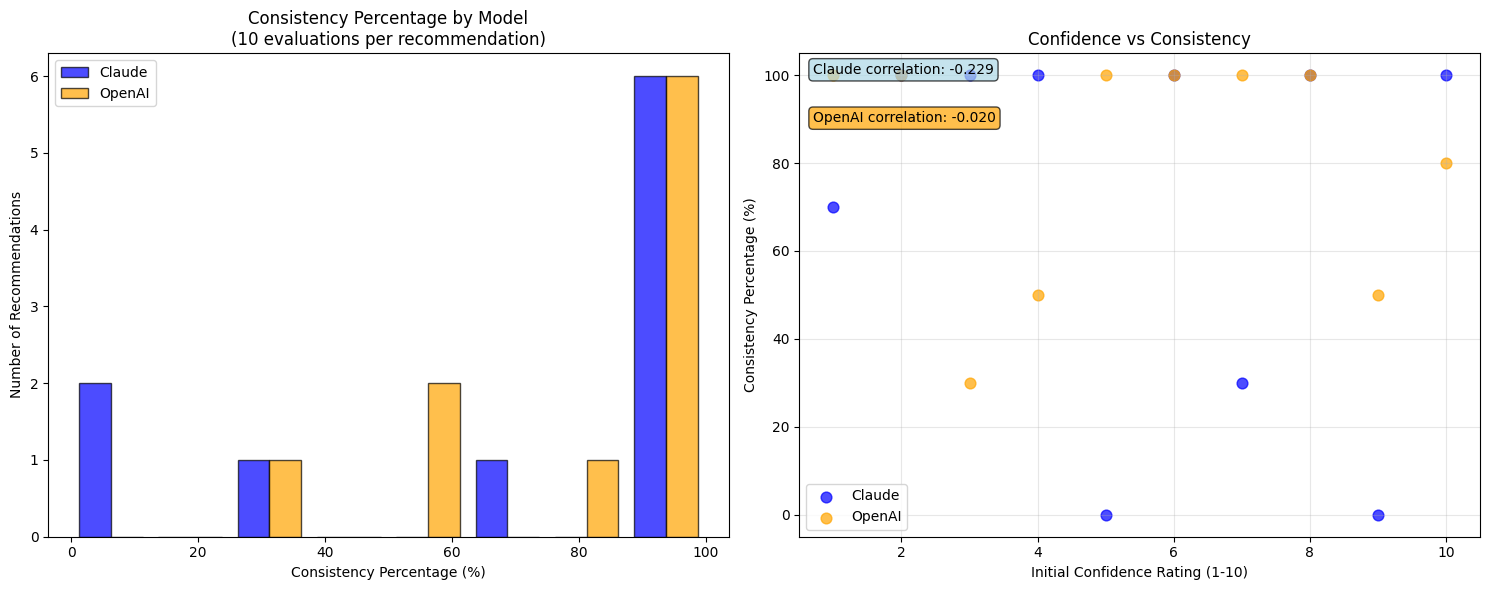

In [ ]:
li_article_experiment.create_inconsistency_histogram()

### Show Detailed Breakdown

In [ ]:
li_article_experiment.show_detailed_breakdown()


DETAILED CONSISTENCY BREAKDOWN:
claude_1 [CLAUDE] - ✓ PERFECTLY CONSISTENT (confidence: 10)
  Good: 10/10 (100.0%)
  Bad: 0/10 (0.0%)
  Recommendation: "Overweight mega-cap technology stocks (Microsoft, Meta) with AI exposure - targe..."

claude_2 [CLAUDE] - ⚠ 0.0% CONSISTENT (confidence: 9)
  Good: 0/10 (0.0%)
  Bad: 10/10 (100.0%)
  Recommendation: "Allocate 15-20% to U.S. industrials sector which is up 15% YTD vs 6% for S&P 500..."

claude_3 [CLAUDE] - ✓ PERFECTLY CONSISTENT (confidence: 8)
  Good: 10/10 (100.0%)
  Bad: 0/10 (0.0%)
  Recommendation: "Maintain overweight position in U.S. equities at 60-65% of equity allocation, su..."

claude_4 [CLAUDE] - ⚠ 30.0% CONSISTENT (confidence: 7)
  Good: 3/10 (30.0%)
  Bad: 7/10 (70.0%)
  Recommendation: "Implement defensive positioning by allocating 5-10% to luxury goods companies li..."

claude_5 [CLAUDE] - ✓ PERFECTLY CONSISTENT (confidence: 6)
  Good: 10/10 (100.0%)
  Bad: 0/10 (0.0%)
  Recommendation: "Reduce exposure to global automa

### For LI Article

In [ ]:
li_article_experiment.export_charts()

✓ Histogram exported to llm_consistency_histogram.png
✓ Scatter plot exported to llm_consistency_scatter.png

Both charts exported at 150 DPI for publication quality
Files: llm_consistency_histogram.png, llm_consistency_scatter.png


In [ ]:
li_article_experiment.get_article_facts()

ARTICLE FACTS:

KEY INCONSISTENCY METRICS:
- 40.0% of recommendations showed some inconsistency (rated as 'bad' at least once)
- 2 recommendations were rated as 'bad' 100% of the time
- Average consistency across all recommendations: 75.5%
- Total recommendations analyzed: 20 (10 evaluations each)

BY MODEL BREAKDOWN:
Claude:
- 4/10 recommendations showed inconsistency (40.0%)
- 2 recommendations rated 'bad' 100% of the time
- Average consistency: 70.0%

OpenAI:
- 4/10 recommendations showed inconsistency (40.0%)
- 0 recommendations rated 'bad' 100% of the time
- Average consistency: 81.0%

Claude confidence-consistency correlation: -0.229
OpenAI confidence-consistency correlation: -0.020

ARTICLE-READY SENTENCES:
"I measured its response 10 times per recommendation. 40.0% of the time the LLM rated its own 'good' advice as 'bad' at least one time. For 2 recommendations, the LLM rated its advice as 'bad' 100% percent of the time! Not too confidence inspiring for our free financial advis

'ARTICLE FACTS:\n\nKEY INCONSISTENCY METRICS:\n- 40.0% of recommendations showed some inconsistency (rated as \'bad\' at least once)\n- 2 recommendations were rated as \'bad\' 100% of the time\n- Average consistency across all recommendations: 75.5%\n- Total recommendations analyzed: 20 (10 evaluations each)\n\nBY MODEL BREAKDOWN:\nClaude:\n- 4/10 recommendations showed inconsistency (40.0%)\n- 2 recommendations rated \'bad\' 100% of the time\n- Average consistency: 70.0%\n\nOpenAI:\n- 4/10 recommendations showed inconsistency (40.0%)\n- 0 recommendations rated \'bad\' 100% of the time\n- Average consistency: 81.0%\n\nClaude confidence-consistency correlation: -0.229\nOpenAI confidence-consistency correlation: -0.020\n\nARTICLE-READY SENTENCES:\n"I measured its response 10 times per recommendation. 40.0% of the time the LLM rated its own \'good\' advice as \'bad\' at least one time. For 2 recommendations, the LLM rated its advice as \'bad\' 100% percent of the time! Not too confidence 